In [4]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pyabf
import traceback
import shelve
import pickle
from math import floor

In [5]:
save_path = '/network/lustre/iss01/wyart/analyses/mathilde.lapoix/MLR/V2a_recruitment_behavior/analysis_9/'
df_summary = pd.read_csv('/network/lustre/iss01/wyart/analyses/2pehaviour/MLR_analyses/data_summary_BH.csv')
df = pd.read_csv(save_path + '/df.csv')
df = df.drop('Unnamed: 0', axis=1)

## Plot example of cells recruitment during spont or MLR triggered forward bouts

In [6]:
exp = 12

try:
    # Load corresponding behavior
    output_path = df_summary.output_path[exp]
    fps_bh = df_summary.frameRateBeh[exp]
    fps_ci = df_summary.frameRate[exp]
    tail_angle = np.load(output_path + '/dataset/tail_angle.npy')
    df_frame = pd.read_pickle(output_path + '/dataset/df_frame')
    df_syl = pd.read_pickle(output_path + '/dataset/df_syllabus_manual')
    time_indices_bh = np.load(output_path + '/dataset/time_indices.npy')
    fish = df_summary.fishlabel[exp]
    plane = df_summary.plane[exp]
    real_plane = df_summary.real_plane[exp]
    data_path = df_summary.data_path[exp]
    ops = np.load(data_path + '/suite2p/plane0/ops.npy', allow_pickle=True).item()
    abf = pyabf.ABF(df_summary.stim_trace_path.iloc[exp])
    # Get time at which behavior camera started
    channel_camera = [i for i, a in enumerate(abf.adcNames) if a in ['IN 0', 'IN 10', 'Behavior']][0]
    abf.setSweep(sweepNumber=0, channel=channel_camera)
    shift = abf.sweepX[np.where(abf.sweepY > 1)[0][0]]
    channel_stim = [i for i, a in enumerate(abf.adcNames) if a in ['Stim', 'Stim_OUT']][0]
    abf.setSweep(sweepNumber=0, channel=channel_stim)
    print('\n\n{}, {},\n{}'.format(fish, plane, output_path))
except FileNotFoundError:
    traceback.print_exc()

with shelve.open(output_path + '/shelve_calciumAnalysis.out') as f:
    cells = f['cells']
    dff = f['dff_c']
    dff_f = f['dff_f_avg']
    dff_f_lp = f['dff_f_lp']
    noise = f['noise']
    noise_f = f['noise_f_avg']
    stat = f['stat']

PermissionError: [Errno 13] Permission denied: '/network/lustre/iss01/wyart/rawdata/martin.carbotano/MLR/Calcium_Imaging/210203/imaging/F01/00/suite2p/plane0/ops.npy'

#### plot TA and CI for specific bouts of interest


In [10]:
exp_mask = (df.fishlabel == fish) & (df.plane == plane)
time_indices_ci = np.arange(dff.shape[1])/fps_ci
syls = [0, 1, 2, 3]

# Find cells which respond at least once during those bouts
dict_cells = {}
for syl in syls:
    dict_cells[syl] = set(df[exp_mask & (df.syl == syl) & (df.recruitment_f == 1) &
                             (df.final_cell_group == 'medulla')].cell)


cells_to_plot = dict_cells[0].union(dict_cells[1], dict_cells[2], dict_cells[3])


In [3]:
# Plot
fig, ax = plt.subplots(figsize=(7, 12))
fig.suptitle(fish + '_' + plane)
time_inf, time_sup = 0, (6340/fps_bh)+2

bh_inf, bh_sup = int(time_inf*fps_bh), int(time_sup*fps_bh)
ax.plot(time_indices_bh[bh_inf:bh_sup], tail_angle[bh_inf:bh_sup]-20, color='black', linewidth=0.5)

ci_inf, ci_sup = floor(time_inf*fps_ci), floor(time_sup*fps_ci)
for i, cell in enumerate(cells_to_plot):
    try:
        ax.plot(time_indices_ci[ci_inf:ci_sup], dff_f_lp[int(cell),ci_inf:ci_sup]+i*10, linewidth=1)
    except IndexError:
        continue

ax.set_xlabel('Time [s]')
ax.set_ylabel('Tail angle [°] / DF/F [%]')
plt.tight_layout()
plt.savefig(save_path + 'example_spont.svg')

# plot maps of recruitment and DF/F during those bouts
fig_r, ax_r = plt.subplots(4,1,figsize=(7, 12))
fig_r.suptitle(fish + '_' + plane+'\nrecruitment')

fig_dff, ax_dff = plt.subplots(4,1,figsize=(7, 12))
fig_dff.suptitle(fish + '_' + plane+'\nmax DF/F')
for syl in syls:
    ax_r[syl].imshow(ops['meanImg'], cmap='Greys')
    sns.scatterplot(data=df[exp_mask & (df.syl == syl) & (df.cell.isin(cells_to_plot))],
                    x='y_pos', y='x_pos', hue='recruitment_f', ax=ax_r[syl])
    ax_dff[syl].imshow(ops['meanImg'], cmap='Greys')
    sns.scatterplot(data=df[exp_mask & (df.syl == syl) & (df.cell.isin(cells_to_plot))],
                    x='y_pos', y='x_pos', hue='norm_max_dff_f', hue_norm=(0,10),
                    ax=ax_dff[syl], palette='rocket_r')
# fig_dff.savefig(save_path + '/dff_map.svg')
# fig_r.savefig(save_path + '/recruitment_map.svg')

NameError: name 'plt' is not defined

## Spline tail angle and tail beat frequency to find cells whose activity correlate with either

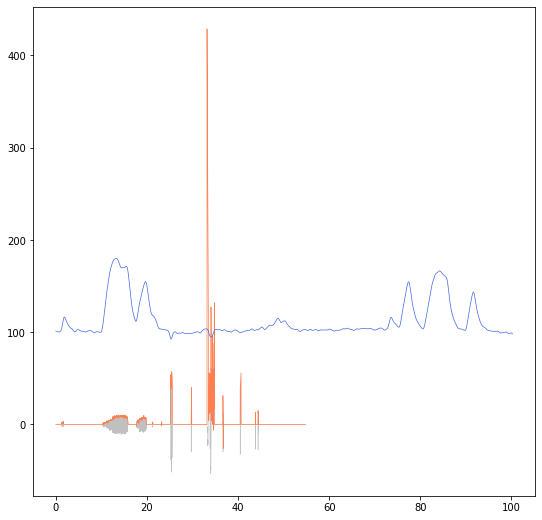

In [16]:
### TA value:
#### method: from tail angle of forward bouts, connect with a spline of the positive bends

# prevent recursion error
df_frame = pd.read_csv(output_path + '/dataset/df_frame.csv')

from scipy.interpolate import interp1d

pos_bends_idx = np.array(df_frame[df_frame.Bend_Amplitude > 0].index)
pos_bends_amp = np.array(df_frame[df_frame.Bend_Amplitude > 0].Bend_Amplitude)
up_enveloppe = interp1d(pos_bends_idx, pos_bends_amp, kind='cubic', bounds_error=False, fill_value=0.0)
enveloppe = up_enveloppe(np.arange(len(tail_angle)))
enveloppe[np.where(tail_angle == 0)] = 0


fig, ax = plt.subplots(figsize=(9,9))
ax.plot(time_indices_bh, tail_angle, color='silver', linewidth=0.5)
ax.plot(time_indices_bh, enveloppe, color='coral', linewidth=0.7)
ax.plot(time_indices_ci, dff_f_lp[60,:]+100, color='royalblue', linewidth=0.7)


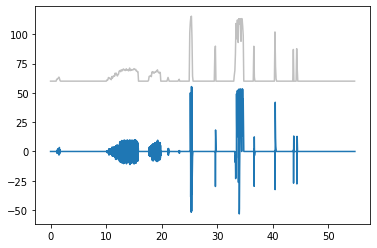

In [24]:
def resample(tail_angle, fps_bh, fps_ci):
    fq1 = str(round(1/fps_bh, 6))+'S'
    fq2 = str(round(1/fps_ci, 6))+'S'
    df_ta = pd.Series(np.abs(tail_angle), index=pd.date_range(start="00:00:00",
                                                      periods=len(tail_angle),
                                                      freq=fq1))
    ta_resampled = np.array(df_ta.resample(fq2).max())
    
    return ta_resampled
    

tail_angle_resampled = resample(tail_angle, fps_bh, fps_ci)

plt.plot(time_indices_bh, tail_angle)
plt.plot(time_indices_ci[0:len(tail_angle_resampled)], tail_angle_resampled+60, color='silver')


#### Plot tail angle resampled against activity of manually selected cells

In [2]:
# manual selection of cells
# manual_cells = [6, 53, 57, 59, 60, 61,62,63,64,65,66,67,68,69,70,72,73,74,76,82,85,87, 92,93,98]
manual_cells = [int(i) for i in cells]

# cut signal just before occurences of struggle like behavior
max_frame = next(frame for frame in np.arange(len(tail_angle_resampled)) if tail_angle_resampled[frame] > 30)-10

# Plot TA against CI
fig, ax = plt.subplots(figsize=(7, 12))
ax.plot(time_indices_ci[0:max_frame], tail_angle_resampled[0:max_frame]-60, color='black', linewidth=0.5)
for i, cell in enumerate(manual_cells):
    ax.plot(time_indices_ci[0:max_frame], dff_f_lp[int(cell),0:max_frame]+i*10, linewidth=1)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Tail angle [°] / DF/F [%]')
plt.tight_layout()


NameError: name 'cells' is not defined

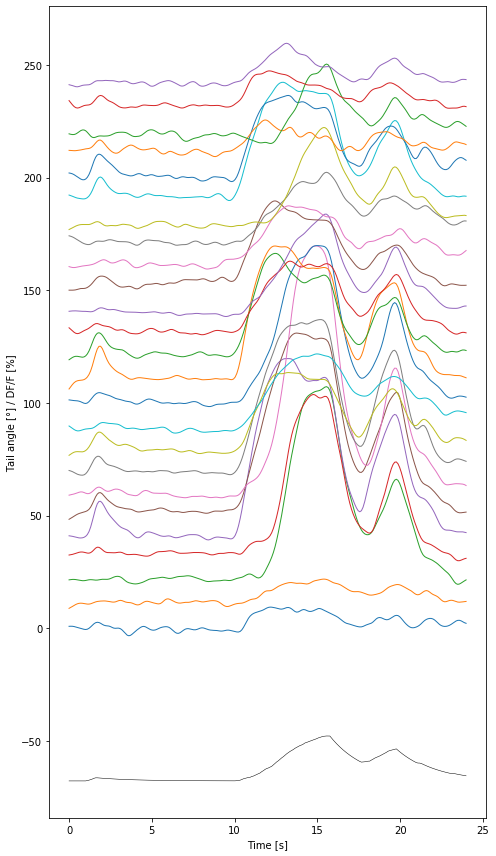

In [118]:
### Build regressor and compute correlation to regressor

from scipy.stats import zscore


def nandot(X, Y):
    """Sum two arrays, but taking the NaN into account (sum functions does not naturally)"""
    return np.nansum(X * Y)


def calcium_kernel(tau):
    """Builds calcium transient trace, based on a tau value defined by user.

    :param tau: The tau value you want to give to your exponential decay

    :return: exponential function with tau decay
    """
    return lambda x: np.exp(- x / (tau / np.log(2)))


def convolve_regressors(regressor, kernel):
    """ Convolves the regressor with a kernel function
    :param regressor: the regressor, or regressor matrix
    :param kernel:
    :return: the convolved kernel
    """
    return np.convolve(regressor, kernel)[0:len(regressor)]


def create_regressor(ta_resampled,  tau: float, fps_ci: float):
    """
    Create motor regressor; e.g signal mimicking fluorescence of a cell expressing calcium indicator
    if it was linearlt encoding the behavior of interest.

    :param ta_resampled: array of tail angle resampled at matching frequency of acquisition with the calcium signal
    :param tau: tau decay of calcium kernel
    :param fps_ci: float, frequency of acquisition of the calcium imaging signal
    :return:
    """


    ker = calcium_kernel(tau)(np.arange(0, 10, 1 / fps_ci))
    ker_zeros = np.zeros((int(2 * fps_ci)))
    ker2 = np.concatenate((ker_zeros, ker, ker_zeros))

    regressor = zscore(convolve_regressors(np.array(ta_resampled).flatten(), ker))


    return regressor


def pearson_coef(cell, regressor, dff, lim_sup):
    """ Calculates the pearson coefficient value between two signal.

    :param pixel: numpy array of the pixel intensity in time
    :param regressor: numpy array of whatever signal you want to correlate your pixel intensity with. Here, tail angle trace.

    :return: pearson correlation coefficient between the 2 signals.
    """
    X = dff[cell,0:lim_sup]
    Y = regressor[0:lim_sup]

    numerator = nandot(X, Y) - X.shape[0] * np.nanmean(X) * np.nanmean(Y)
    denominator = (X.shape[0] - 1) * np.nanstd(X) * np.nanstd(Y)
    pearson_corr = numerator / denominator
    return pearson_corr


# Compute regressor
regressor = create_regressor(tail_angle_resampled, 1.5, fps_ci)


# Plot TA against CI
fig, ax = plt.subplots(figsize=(7, 12))
ax.plot(time_indices_ci[0:max_frame], regressor[0:max_frame]*10-60, color='black', linewidth=0.5)
for i, cell in enumerate(manual_cells):
    ax.plot(time_indices_ci[0:max_frame], dff_f_lp[int(cell),0:max_frame]+i*10, linewidth=1)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Tail angle [°] / DF/F [%]')
plt.tight_layout()

# Compute correlation
df_correlation = pd.DataFrame({'cell': manual_cells, 
                               'x_pos': np.nan, 
                               'y_pos': np.nan,
                               'motor_correlation': np.nan}, index=np.arange(len(manual_cells)))
for i in df_correlation.index:
    cell = df_correlation.cell[i]
    try:
        df_correlation.at[i, 'x_pos'] = df[exp_mask & (df.syl == 0) & (df.cell == cell)].x_pos
        df_correlation.at[i, 'y_pos'] = df[exp_mask & (df.syl == 0) & (df.cell == cell)].y_pos
    except ValueError:
        df_correlation.at[i, 'x_pos'], df_correlation.at[i, 'y_pos'] = np.nan, np.nan
    
df_correlation['motor_correlation'] = df_correlation.cell.apply(pearson_coef, args=(regressor, dff_f_lp, max_frame))

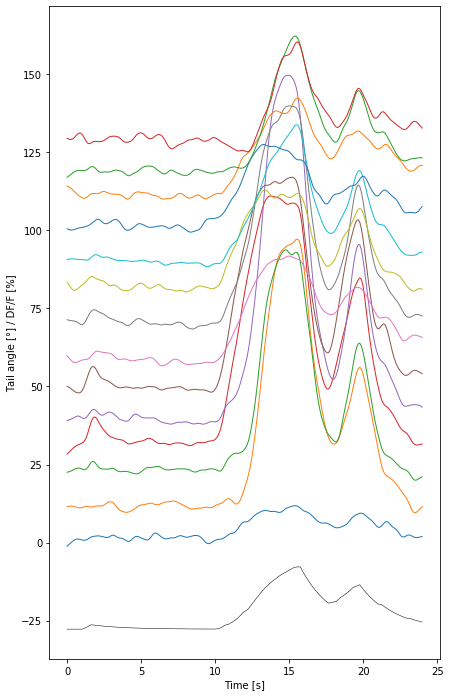

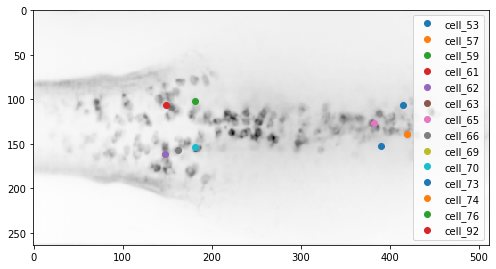

In [119]:
#### Plot cells with really high correlation
max_cells = df_correlation[df_correlation.motor_correlation > 0.9].cell

fig, ax = plt.subplots(figsize=(7, 12))
ax.plot(time_indices_ci[0:max_frame], regressor[0:max_frame]*10-20, color='black', linewidth=0.5)

fig_p, ax_p = plt.subplots(figsize=(7, 12))
ax_p.imshow(ops['meanImg'], cmap='Greys')

for i, cell in enumerate(max_cells):
    ax.plot(time_indices_ci[0:max_frame], dff_f_lp[int(cell),0:max_frame]+i*10, linewidth=1, label='cell_'+str(cell))
    ax_p.plot(df[exp_mask & (df.syl == 0) & (df.cell == cell)].y_pos, df[exp_mask & (df.syl == 0) & (df.cell == cell)].x_pos, 'o',
             label='cell_'+str(cell))
ax.set_xlabel('Time [s]')
ax.set_ylabel('Tail angle [°] / DF/F [%]')
plt.tight_layout()
plt.legend()



### Tail beat frequency:
#### bin behavior, compute median tail beat frequency in this bin, and build a spline between the 

2) Regressor of median tail angle during bin

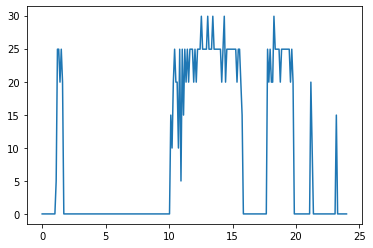

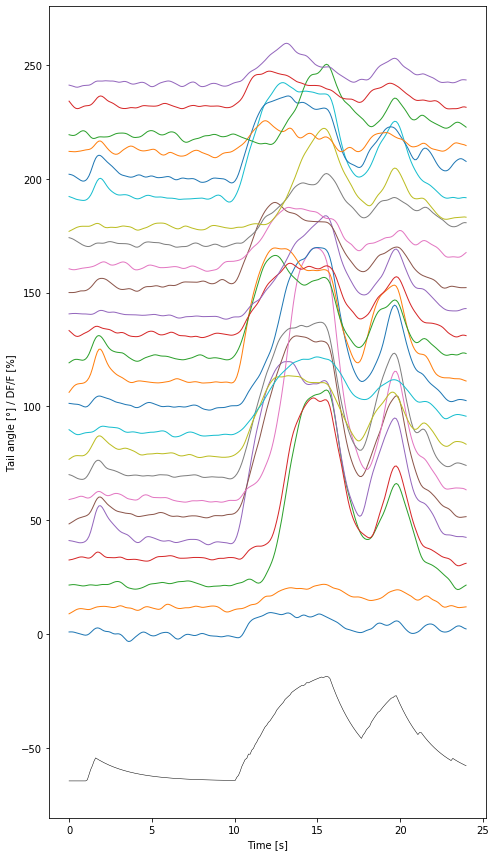

In [120]:
def bin_mean_freq(frame):
    try:
        time = time_indices_ci[frame]
        next_time = time_indices_ci[frame+1]
        bh_inf, bh_sup = int(time*fps_bh), int(next_time*fps_bh)
        n_osc = len(df_frame[(df_frame.index.isin(range(bh_inf, bh_sup))) & (df_frame.Bend_Amplitude.notna())])/2
        if n_osc != 0:
            output = n_osc * fps_ci
        else:
            output = 0
    except IndexError:
        output = 0
    return output
        
        
freq_array = pd.Series(np.arange(len(time_indices_ci))).apply(bin_mean_freq)
plt.figure()
plt.plot(time_indices_ci[:max_frame], freq_array[:max_frame])

# Compute regressor
regressor_freq = create_regressor(freq_array, 1.5, fps_ci)


# Plot TA against CI
fig, ax = plt.subplots(figsize=(7, 12))
ax.plot(time_indices_ci[0:max_frame], regressor_freq[0:max_frame]*10-60, color='black', linewidth=0.5)
for i, cell in enumerate(manual_cells):
    ax.plot(time_indices_ci[0:max_frame], dff_f_lp[int(cell),0:max_frame]+i*10, linewidth=1)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Tail angle [°] / DF/F [%]')
plt.tight_layout()

# Compute correlation
df_correlation['freq_correlation'] = df_correlation.cell.apply(pearson_coef, args=(regressor_freq, dff_f_lp, max_frame))

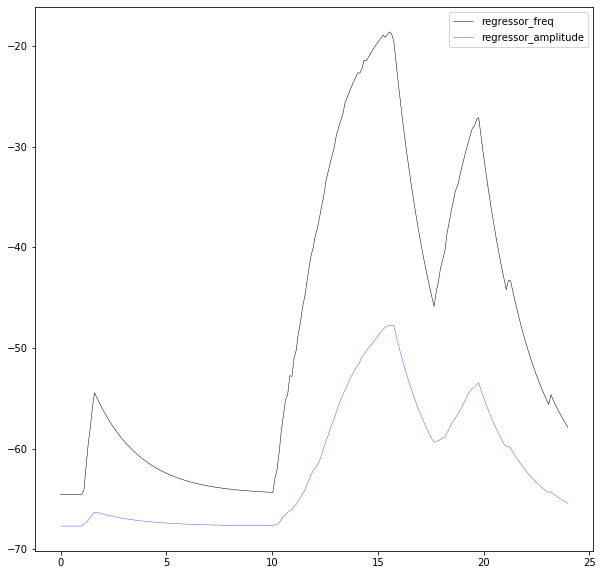

In [121]:
plt.figure(figsize=(10,10))
plt.plot(time_indices_ci[0:max_frame], regressor_freq[0:max_frame]*10-60, color='black', linewidth=0.5, label='regressor_freq')
plt.plot(time_indices_ci[0:max_frame], regressor[0:max_frame]*10-60, color='royalblue', linewidth=0.5, label='regressor_amplitude')
plt.legend()

In [1]:
max_cells_freq = df_correlation[df_correlation.freq_correlation > 0.75].cell

fig, ax = plt.subplots(figsize=(7, 12))
fig.suptitle('Traces of cells highly correlated to freq regressor')
ax.plot(time_indices_ci[0:max_frame], regressor_freq[0:max_frame]*10-20, color='black', linewidth=0.5)

fig_p, ax_p = plt.subplots(figsize=(7, 12))
fig_p.suptitle('Pos cells highly correlated to freq regressor')
ax_p.imshow(ops['meanImg'], cmap='Greys')

for i, cell in enumerate(max_cells_freq):
    ax.plot(time_indices_ci[0:max_frame], dff_f_lp[int(cell),0:max_frame]+i*10, linewidth=1, label='cell_'+str(cell))
    ax_p.plot(df[exp_mask & (df.syl == 0) & (df.cell == cell)].y_pos, df[exp_mask & (df.syl == 0) & (df.cell == cell)].x_pos, 'o',
             label='cell_'+str(cell))
ax.set_xlabel('Time [s]')
ax.set_ylabel('Tail angle [°] / DF/F [%]')
plt.tight_layout()
plt.legend()

NameError: name 'df_correlation' is not defined

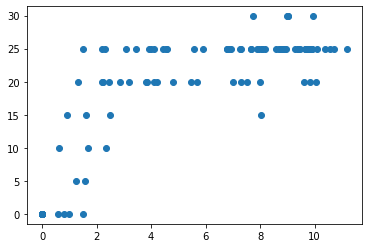

(0.6, 1)

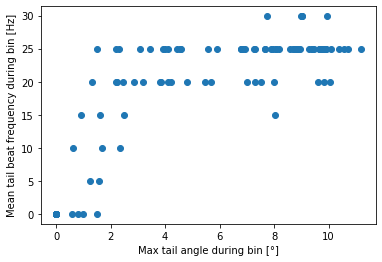

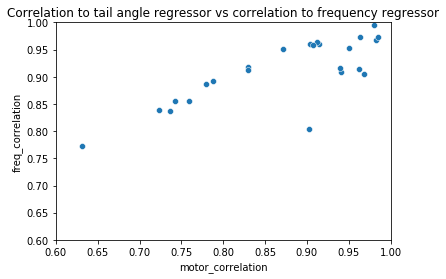

In [92]:
plt.plot(tail_angle_resampled[:max_frame], freq_array[:max_frame], 'o')
plt.xlabel('Max tail angle during bin [°]')
plt.ylabel('Mean tail beat frequency during bin [Hz]')
plt.figure()
plt.title('Correlation to tail angle regressor vs correlation to frequency regressor')
sns.scatterplot(data=df_correlation, x='motor_correlation', y='freq_correlation')
plt.xlim(0.6,1)
plt.ylim(0.6,1)

### Plot which neurons are more correlated to freq or amplitude modulation

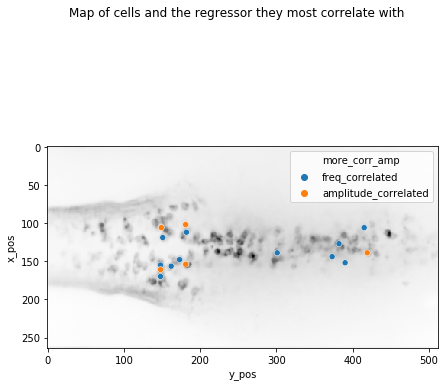

In [124]:
df_correlation['more_corr_amp'] = df_correlation['motor_correlation'] > df_correlation['freq_correlation']
df_correlation['more_corr_amp'] = df_correlation['more_corr_amp'].replace([False, True], ['freq_correlated', 'amplitude_correlated'])

fig, ax = plt.subplots(figsize=(7, 7))
fig.suptitle('Map of cells and the regressor they most correlate with')

ax.imshow(ops['meanImg'], cmap='Greys')
sns.scatterplot(data=df_correlation, x='y_pos', y='x_pos', hue='more_corr_amp', ax=ax)